In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Worldwide ratio by day

In [2]:
DATA_FOLDER = "./"

In [3]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)


Regions list: ['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


,Country,Region,FIPS,ISO
0,Afghanistan,Asia,AF,AF
278,Aland Islands,Europe,NaN,AX
2,Albania,Europe,AL,AL
3,Algeria,Africa,AG,DZ
4,American Samoa,Oceania,AQ,AS
5,Andorra,Europe,AN,AD
6,Angola,Africa,AO,AO
7,Anguilla,Americas,AV,AI
8,Antarctica,NaN,AY,AQ
9,Antigua and Barbuda,Americas,AC,AG


In [4]:
countries.to_csv("preprocessed_countries.csv")

In [5]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_months_filtered_5themes.csv"

In [6]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.loc[counts.ENV_COUNT.isna(), "ENV_COUNT"] = 0
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    counts = counts[["DATE", "STATE", "ISO", "Country", "Region", "GLOBAL_COUNT", "ENV_COUNT", "Ratio"]]
    return counts

In [7]:
counts = read_csv(counts_file)
counts = counts.groupby(["DATE"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,1.010000e+03,1010.000000,1010.000000
mean,2.019878e+06,24810.514851,0.012572
std,5.086548e+05,14015.672089,0.008117
min,4.195200e+04,599.000000,0.004059
25%,1.570417e+06,16721.500000,0.008574
50%,2.135384e+06,22554.000000,0.010717
75%,2.398692e+06,29062.250000,0.013750
max,3.570019e+06,135549.000000,0.129065


Text(0, 0.5, 'Ratio')

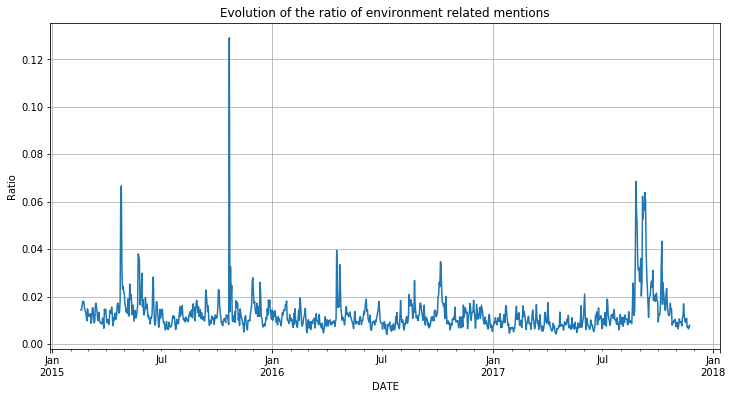

In [8]:
ax = counts.plot.line(x="DATE", y=["Ratio"], figsize=(12, 6), legend=None, grid=True,
                 title="Evolution of the ratio of environment related mentions")
ax.set_ylabel("Ratio")

In [9]:
counts[counts.Ratio>0.47].sort_values("Ratio", ascending=False)

,DATE,GLOBAL_COUNT,ENV_COUNT,Ratio


# Ratio by european countries

In [10]:
counts = read_csv(counts_file, countries[countries.Region=="Europe"].FIPS.values)
counts.describe()

,GLOBAL_COUNT,ENV_COUNT,Ratio
count,53490.000000,53490.000000,53490.000000
mean,27402.080651,74.114246,0.039833
std,79715.525324,316.232744,0.095915
min,1.000000,0.000000,0.000000
25%,124.000000,0.000000,0.000000
50%,576.000000,8.000000,0.013477
75%,3060.750000,38.000000,0.038168
max,446447.000000,28937.000000,1.000000


In [11]:
europe_counts = counts.groupby(["ISO", "Country"]).sum()
europe_counts = europe_counts.assign(Ratio=europe_counts.ENV_COUNT/europe_counts.GLOBAL_COUNT)
europe_counts.sort_values("GLOBAL_COUNT", ascending=False).head(20)

,,GLOBAL_COUNT,ENV_COUNT,Ratio
ISO,Country,,,
GG,Guernsey,267359509,0.0,0.000000
JE,Jersey,267359509,0.0,0.000000
IM,Isle of Man,267359509,0.0,0.000000
AX,Aland Islands,267359509,0.0,0.000000
BQ,"Bonaire, Sint Eustatius and Saba",267359509,0.0,0.000000
GB,United Kingdom,31432644,782646.0,0.024899
RU,Russian Federation,22766634,683460.0,0.030020
FR,France,14500804,621951.0,0.042891
DE,Germany,10237250,261671.0,0.025561


In [12]:
import json
import folium
import pygeoj
import branca

In [13]:
geo_json_data = pygeoj.load("europe.geojson")

In [14]:
results_map = folium.Map([49,15], tiles='cartodbpositron', zoom_start=4)

In [15]:
europe_counts = europe_counts.reset_index()

In [16]:
colorscale = branca.colormap.linear.YlOrRd_09.scale(0, max(europe_counts['Ratio']))

In [17]:
def style_function(feature):
    value = europe_counts.loc[europe_counts['ISO']==feature['properties']['ISO2']].Ratio.values
    if(len(value)>0):
        value = value[0]
    else:
        value = None
    return {
        'fillOpacity': 0.6,
        'weight': 0,
        'fillColor': '#black' if value is None else colorscale(value)
    }

In [18]:
folium.GeoJson(
    geo_json_data,
    style_function=style_function
    ).add_to(results_map)

In [19]:
results_map.add_child(colorscale)